In [4]:
import torch
from torch import cuda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np
import pandas as pd

from string import punctuation
from collections import Counter
from tqdm import tqdm
import pickle

In [11]:
with open(r"C:\Users\Andrey\Google Диск\DeepPavlov\text8","r") as f:
  data = f.read()

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Andrey\\Google Диск\\DeepPavlov\\text8'

In [0]:
from string import punctuation
corpus = ''.join([c.lower() for c in data if c not in punctuation+'«»']).split()

In [0]:
# считаем слова и сортируем по убыванию количества вхождений
def counter(words):
  count_words = Counter(words)
  total_words = len(words)
  sorted_words = count_words.most_common(total_words)
  print('total words: {}'.format(total_words))
  print(sorted_words[150:200])
  less_10, more_10 = 0, 0
  for word,freq in sorted_words:
    if freq>10:
        more_10+=1
    if freq<10:
        less_10+=1
  print('more then 10: {}, less then 10: {}'.format(more_10,less_10))
  return sorted_words, more_10


# назначаю каждому токену номер
def make_dicts(sorted_words, dimensionality):
  word2index = {w:i+1 for i, (w,c) in enumerate(sorted_words[:(dimensionality-1)])}   
  word2index['UNK'] = 0
  index2word = {i+1:w for i, (w,c) in enumerate(sorted_words[:(dimensionality-1)])}
  index2word[0] = 'UNK'
  return word2index, index2word


class Data_Processing_CBOW():
  def __init__(self, corpus, window_size):
    self.corpus = corpus
    self.window_size = window_size
    self.dimensionality = np.nan


  def get_data(self):
    sorted_words, self.dimensionality = counter(self.corpus)
    word2index, index2word = make_dicts(sorted_words, self.dimensionality)
    # собственно делаем X,y
    X,y = [],[]
    num_sent = [word2index[x] if x in word2index.keys() else 0 for x in self.corpus]
    for cur_idx,num in enumerate(num_sent[self.window_size:-self.window_size]):
      idx = cur_idx+self.window_size
      y.append(num)
      X.append(num_sent[idx-self.window_size:idx]+num_sent[idx+1:idx+self.window_size+1])

    return np.array(X), np.array(y), word2index, index2word

In [5]:
X, y, word2index, index2word = Data_Processing_CBOW(corpus, 5).get_data()

total words: 17005207
[('french', 8736), ('before', 8700), ('general', 8659), ('what', 8581), ('t', 8491), ('against', 8432), ('n', 8372), ('high', 8337), ('links', 8312), ('could', 8304), ('based', 8244), ('those', 8209), ('now', 8206), ('second', 8110), ('de', 8002), ('music', 7987), ('another', 7933), ('large', 7898), ('she', 7896), ('f', 7878), ('external', 7862), ('german', 7858), ('different', 7797), ('modern', 7790), ('great', 7770), ('do', 7763), ('common', 7698), ('set', 7682), ('list', 7672), ('south', 7628), ('series', 7611), ('major', 7585), ('game', 7553), ('power', 7522), ('long', 7488), ('country', 7481), ('king', 7456), ('law', 7435), ('group', 7417), ('film', 7400), ('still', 7378), ('until', 7368), ('north', 7328), ('international', 7262), ('term', 7219), ('we', 7118), ('end', 7113), ('book', 7110), ('found', 7043), ('own', 7034)]
more then 10: 44611, less then 10: 206720


In [0]:
# import shutil
# shutil.move('w2v_data.pkl', "/content/gdrive/My Drive/DeepPavlov/w2v_data.pkl") 

'/content/gdrive/My Drive/DeepPavlov/w2v_data.pkl'

In [6]:
print(X.shape, y.shape)

(17005197, 10) (17005197,)


In [0]:
class My_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]


class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_percent_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop_training(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(round(100*gain,2)))
        if gain < self.min_percent_gain:
            return True
        else:
            return False

def weights_init(m):
    classname = m.__class__.__name__

    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)

    elif classname.find('Embedding') != -1:
        torch.nn.init.xavier_uniform_(m.weight)

In [0]:
class model(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
      super().__init__()

      self.emb = nn.Embedding(vocab_size, embedding_dim)
      self.linear = nn.Linear(embedding_dim, vocab_size)


    def forward(self, x):
      out = torch.sum(self.emb(x), dim=1)  # [batch_size, 2*window_size, 20000] => [batch_size, 20000]
      out = self.linear(out)
      # print(out.shape)
      out = F.log_softmax(out, dim=1)
      # print(out.shape)

      return out

    def word_embeddings(self, word):                          # функция для п.3 function to map token to corresponding word vector
      word = torch.LongTensor([word2index[word]])     
      if cuda.is_available():
          word = word.cuda()
      else:
          self.cpu()
      return self.emb(word)


net = model(len(word2index.keys()), 300)

In [0]:
print_every = 10
num_epochs = 100
batch_size = 512
lr = 0.01

batcher_train = DataLoader(My_Dataset(X, y), batch_size=batch_size, shuffle=False)
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [0]:
# https://github.com/jeffchy/pytorch-word-embedding/blob/master/CBOW.py              самая толковая версия
# https://github.com/FraLotito/pytorch-continuous-bag-of-words/blob/master/cbow.py   реализована get_embeddings


if cuda.is_available():
    net = net.cuda()

# cбросить веса
# net.apply(weights_init)


train_loss=[]
train_accuracy=[]

early_stopping = EarlyStopping()


for epoch in range(num_epochs):

    iter_loss = 0.0
    correct = 0
    iterations = 0

    net.train()  # Put the network into training mode

    for i, (items, classes) in tqdm(enumerate(batcher_train)):

        # Convert torch tensor to Variable
        items = Variable(torch.LongTensor(items))
        classes = Variable(torch.LongTensor(classes))

        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()

        net.zero_grad()  # Clear off the gradients from any past operation
        outputs = net(items)   # Do the forward pass

        lr = lr / (2**(epoch // 10))
        for param_group in optimizer.param_groups:
          param_group['lr'] = lr


        loss = F.nll_loss(outputs, classes)                                          
        iter_loss += loss.item()  # Accumulate the loss
        loss.backward()  # Calculate the gradients with help of back propagation
        optimizer.step()  # Ask the optimizer to adjust the parameters based on the gradients

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)

        
        correct += (predicted == classes.data).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(batcher_train.dataset)))
    print(100.0 * correct / len(batcher_train.dataset))                                                   


    train_loss.append(train_loss[-1])
    train_accuracy.append(train_accuracy[-1])

    early_stopping.update_loss(train_loss[-1])
    if early_stopping.stop_training():
        break
    
    # if epoch%print_every==0:
    print('Epoch %d/%d, Tr Loss: %.4f, Tr Accuracy: %.1f'
          % (epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1]))
    

  torch.save(net, 'net.pb')
  files.download('net.pb') 

tensor(9.1052, device='cuda:0')
Epoch 1/100, Tr Loss: 8.0341, Tr Accuracy: 9.0
tensor(9.7169, device='cuda:0')
Loss gain: 9.43%
Epoch 2/100, Tr Loss: 7.2763, Tr Accuracy: 9.0
tensor(10.0751, device='cuda:0')
Loss gain: 11.6%
Epoch 3/100, Tr Loss: 7.1019, Tr Accuracy: 10.0
tensor(10.3960, device='cuda:0')
Loss gain: 12.77%
Epoch 4/100, Tr Loss: 7.0085, Tr Accuracy: 10.0
tensor(10.6922, device='cuda:0')
Loss gain: 13.56%
Epoch 5/100, Tr Loss: 6.9443, Tr Accuracy: 10.0
tensor(10.9554, device='cuda:0')
Loss gain: 5.24%
Epoch 6/100, Tr Loss: 6.8948, Tr Accuracy: 10.0
tensor(11.1890, device='cuda:0')
Loss gain: 3.49%
Epoch 7/100, Tr Loss: 6.8543, Tr Accuracy: 11.0
tensor(11.3926, device='cuda:0')
Loss gain: 2.69%
Epoch 8/100, Tr Loss: 6.8199, Tr Accuracy: 11.0
tensor(11.5709, device='cuda:0')
Loss gain: 2.22%
Epoch 9/100, Tr Loss: 6.7901, Tr Accuracy: 11.0
tensor(11.7228, device='cuda:0')
Loss gain: 1.9%
Epoch 10/100, Tr Loss: 6.7639, Tr Accuracy: 11.0
tensor(11.7972, device='cuda:0')
Loss g

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


MessageError: ignored

In [0]:
# import shutil
# shutil.move("net.pb", "/content/gdrive/My Drive/DeepPavlov/net_text8.pb") 

'/content/gdrive/My Drive/DeepPavlov/net_text8_temp.pb'

#Загружаем уже подсчитанную модель

In [11]:
net = torch.load("/content/gdrive/My Drive/DeepPavlov/net_text8.pb")


from google.colab import drive
drive.mount('/content/gdrive')
with open("/content/gdrive/My Drive/DeepPavlov/w2v_data.pkl","rb") as f:
  [X, y, word2index, index2word] = pickle.load(f) 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
print(net)

model(
  (emb): Embedding(44611, 300)
  (linear): Linear(in_features=300, out_features=44611, bias=True)
)


In [13]:
# net = net.cpu()
# net.emb(torch.LongTensor([word2index['the']])).shape
net.word_embeddings('the').shape

torch.Size([1, 300])

#vizualization

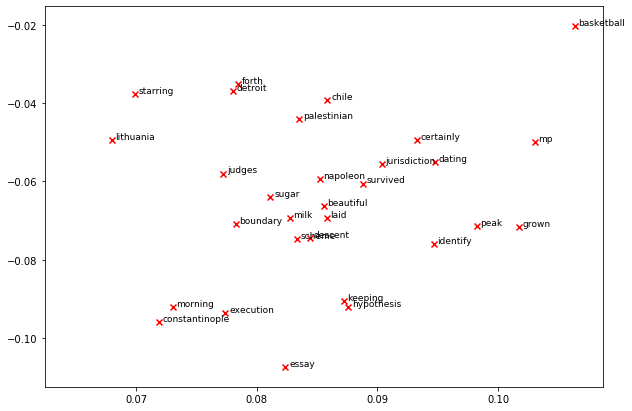

In [0]:
# нарисую все это
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
start, end = 3000, 3030

df = pd.DataFrame(data=net.emb.weight.detach().numpy(), index=[index2word[x] for x in range(len(word2index))])

svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=15, random_state=None)
M_reduced = svd.fit_transform(df.values)


sub_words = df.iloc[start:end,:]
types = sub_words.index
x_coords = M_reduced[start:end,0]
y_coords = M_reduced[start:end,1]

fig = plt.figure(figsize=(10, 7))
for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.0003, y+0.0003, type, fontsize=9)
plt.show()

#intrinsic test

In [0]:
# intrinsic_test
with open("/content/gdrive/My Drive/DeepPavlov/intrinsic_test.txt","r") as f:
  intrinsic_test = f.read()

intrinsic_data = [x.split() for x in intrinsic_test.split('\n')]
intrinsic_data = [x for x in intrinsic_data if len(x)==4]

In [0]:
# https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html   
# standford gensim realization не получилось повторить 

# from gensim.test.utils import datapath, get_tmpfile
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec

# word2vec_glove_file = get_tmpfile("/content/gdrive/My Drive/DeepPavlov/glove.6B.100d.txt")
# model = KeyedVectors.load_word2vec_format(word2vec_glove_file)
# model.most_similar('obama')

In [0]:
# https://programmer.group/pytorch-implements-word2vec.html                                    чувак подкинул
# сделал кастомный вариант подсчета cosine_similarity
def prepare_x(x):
  if x in word2index.keys():
      x = net.emb(torch.LongTensor([word2index[x]]))
      if cuda.is_available():
        x.cuda()
  else:
      x = 'UNK'
  return x
all_values=[]

def cosine_similarity(data):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    [a_,b_,c_,d_] = data

    if cuda.is_available():
      device='cuda'
    else:
      device='cpu'

    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    try:
      a,b,c,d = prepare_x(a_),prepare_x(b_),prepare_x(c_),prepare_x(d_),

      summ = b-a+c
      magn_d = d.pow(2).sum(dim=1).sqrt().unsqueeze(0)
      magn_result = summ.pow(2).sum(dim=1).sqrt().unsqueeze(0)
      
      similarities = torch.mm(d, summ.t())/(magn_d*magn_result)

      # print("{} к {} как {} к {}".format(data[0], data[1], data[2], data[3]))
      # print(similarities.detach().cpu().numpy()[0][0])
      all_values.append(similarities.detach().cpu().numpy()[0][0])
    except:
      pass

In [0]:
for example in intrinsic_data:
  cosine_similarity(example)
print('MEAN {}'.format(np.mean(all_values)))

MEAN 0.205417662858963


#extrinsic test

In [14]:
# взят датасет https://www.kaggle.com/kazanova/sentiment140
from google.colab import drive
drive.mount('/content/gdrive')
raw = pd.read_csv("/content/gdrive/My Drive/DeepPavlov/sentiment140/training.1600000.processed.noemoticon.csv",
            sep=",", encoding='latin-1', header=None).loc[:,[0,5]]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
twits = []
for row in raw[5]:
  temp = row.split()
  temp = ['URL' if c.startswith('http') else c for c in temp]
  temp = ['NAME' if c.startswith('@') else c for c in temp]

  # print(temp)
  twits.append(''.join([c.lower() for c in " ".join(temp) if c not in punctuation+'«»']).split())

In [16]:
raw[5] = twits
raw.rename(columns={0:'target',5:'twit'}, inplace=True)
raw.head()

,target,twit
0,0,"[name, url, awww, thats, a, bummer, you, shoul..."
1,0,"[is, upset, that, he, cant, update, his, faceb..."
2,0,"[name, i, dived, many, times, for, the, ball, ..."
3,0,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"[name, no, its, not, behaving, at, all, im, ma..."


In [17]:
twits_len = [len(twit) for twit in raw[raw['target']==4].twit]
print(np.mean(twits_len), np.std(twits_len))
twits_len = [len(twit) for twit in raw[raw['target']==0].twit]
print(np.mean(twits_len), np.std(twits_len))

12.6207275 6.758350380880216
13.46716625 7.024173399401595


In [0]:
targets = raw.target.tolist()

sub_twits = [twits[i] for i, l in enumerate(twits) if 6<len(l)<20]
sub_targets = [targets[i] for i, l in enumerate(twits) if 6<len(l)<20]
df = pd.DataFrame(columns=raw.columns, index=range(len(sub_targets)))
df['twit'], df['target'] = sub_twits, sub_targets

In [19]:
df['target'].value_counts()

4    469343
0    463323
Name: target, dtype: int64

In [0]:
# https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948
# пока не доделал
sub_twit_tokens = [[word2index[x] if x in word2index.keys() else 0 for x in twit] for twit in sub_twits]

In [0]:
x_train = sub_twit_tokens[:int(0.8*len(sub_targets))]
y_train = sub_targets[:int(0.8*len(sub_targets))]
x_val = sub_twit_tokens[int(0.8*len(sub_targets)):]
y_val = sub_targets[int(0.8*len(sub_targets)):]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(sub_twit_tokens, sub_targets, test_size=0.10, random_state=42, )
np.unique(y_train, return_counts=True)

(array([0, 4]), array([417116, 422283]))

In [0]:
class My_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        batch_x = np.zeros((20,1), dtype=int)
        batch_x[:len(self.x[idx]),0] = self.x[idx]
        

        return batch_x, self.y[idx]


batch_size = 512

batcher_train = DataLoader(My_Dataset(X_train, y_train), batch_size=batch_size, shuffle=True)
batcher_val = DataLoader(My_Dataset(X_val, y_val), batch_size=batch_size, shuffle=True)

In [0]:
class RCNN(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(RCNN, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embedding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.dropout = 0.8
		self.lstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
		self.W2 = nn.Linear(2*hidden_size+embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		"""
		
		The idea of the paper "Recurrent Convolutional Neural Networks for Text Classification" is that we pass the embedding vector
		of the text sequences through a bidirectional LSTM and then for each sequence, our final embedding vector is the concatenation of 
		its own GloVe embedding and the left and right contextual embedding which in bidirectional LSTM is same as the corresponding hidden
		state. This final embedding is passed through a linear layer which maps this long concatenated encoding vector back to the hidden_size
		vector. After this step, we use a max pooling layer across all sequences of texts. This converts any varying length text into a fixed
		dimension tensor of size (batch_size, hidden_size) and finally we map this to the output layer.
		"""
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences, embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
			h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		
		final_encoding = torch.cat((output, input), 2).permute(1, 0, 2)
		y = self.W2(final_encoding) # y.size() = (batch_size, num_sequences, hidden_size)
		y = y.permute(0, 2, 1) # y.size() = (batch_size, hidden_size, num_sequences)
		y = F.max_pool1d(y, y.size()[2]) # y.size() = (batch_size, hidden_size, 1)
		y = y.squeeze(2)
		logits = self.label(y)
		
		return logits

In [74]:
net2 = RCNN(batch_size, 2, 300, len(word2index), 300, net.emb.weight )

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
train_fscore = []
valid_fscore = []

if cuda.is_available():
    net2 = net2.cuda()

# Our loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(100):

    ############################
    # Train
    ############################

    iter_loss = 0.0
    correct = 0
    iterations = 0
    f_scores= 0

    net2.train()  # Put the network into training mode

    for i, (items, classes) in enumerate(batcher_train):

        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)

        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()

        optimizer.zero_grad()  # Clear off the gradients from any past operation
        outputs = net2(items)  # Do the forward pass
        loss = criterion(outputs, classes.long())                                               # Calculate the loss
        iter_loss += loss.item()  # Accumulate the loss
        loss.backward()  # Calculate the gradients with help of back propagation
        optimizer.step()  # Ask the optimizer to adjust the parameters based on the gradients
        print(loss.data)
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data.long()).sum()

        f_scores += f1_score(predicted.cpu().numpy(), classes.data.cpu().numpy(), average='macro')

        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(batcher_train.dataset)))
    train_fscore.append(f_scores/iterations)
    # print(100.0 * correct / len(batcher_train.dataset))                                                   рень с перестановкой множителей местами!

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################


    loss = 0.0
    correct = 0
    iterations = 0
    f_scores = 0

    net2.eval()  # Put the network into evaluate mode

    for i, (items, classes) in enumerate(batcher_val):

        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)

        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()

        outputs = net2(items)  # Do the forward pass
        loss += criterion(outputs, classes.long()).item()  # Calculate the loss
                                                                        # loss = criterion(outputs, classes.long()).sum()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data.long()).sum()

        f_scores += f1_score(predicted.cpu().numpy(), classes.data.cpu().numpy(), average='macro')

        iterations += 1

    # Record the validation loss
    valid_loss.append(loss / iterations)
    # Record the validation accuracy
    valid_accuracy.append(100.0 * correct / float(len(batcher_val.dataset)))
    valid_fscore.append(f_scores/iterations)

    # print(correct, float(len(batcher_val.dataset)))
    # print(100 * correct / float(len(batcher_val.dataset)))


    print('Epoch %d/%d, Tr Loss: %.4f, Tr Fscore: %.4f, Val Loss: %.4f, Val Fscore: %.4f'
          % (epoch + 1, config.num_epochs, train_loss[-1], train_fscore[-1],
              valid_loss[-1], valid_fscore[-1]))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RuntimeError: ignored